## Media Mix Modeling

### Introduction

- This MMM Model built by PyMC Labs is based on the Baysian apporach in [this paper](https://storage.googleapis.com/gweb-research2023-media/pubtools/pdf/b20467a5c27b86c08cceed56fc72ceadb875184a.pdf) by Google.
- This sample work is to show how this MMM model works.
- Note: There are way more work can be done using MMM, such as showing media channel contribution by percentage, showing the budget optimization by media channel. Unforutaly, they do require more time to have them done.

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

### Generate Synthetic Data
- since there is no real dataset, I follow the code instruction, create the syntheic data.
- The data includes:
  Date_week;
  Sales data;
  Media cost of channels: x1 and x2;
  event data

In [44]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
# print(f"Number of observations: {n}")

In [4]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

In [5]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [6]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

In [7]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])


In [8]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

In [9]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)


In [10]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

# print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
# print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

In [11]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()

In [12]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()
data.head()

date_week         y        x1   x2  event_1  event_2  dayofyear
0 2018-04-02  3.984662  0.318580  0.0      0.0      0.0         92
1 2018-04-09  3.762872  0.112388  0.0      0.0      0.0         99
2 2018-04-16  4.466967  0.292400  0.0      0.0      0.0        106
3 2018-04-23  3.864219  0.071399  0.0      0.0      0.0        113
4 2018-04-30  4.441625  0.386745  0.0      0.0      0.0        120

- Here is the output of the data.

In [42]:
df['date_week'] = pd.to_datetime(df['date_week'])

# Find the maximum and minimum dates
max_date = df['date_week'].max()
min_date = df['date_week'].min()

In [43]:
max_date

Timestamp('2021-08-30 00:00:00')

- Here is an output of the data: y is the sales; x1 is channel 1, x2 is channel 2; and the event 1 and event 2 reflex a day that have comperaltivly high sales.

### Feature Engineering
- In practice, I should always have EDA, however, I am skipping it here because of having markup data.
- Adding features as control variables:
  trend;
  yearly_seasonality

In [45]:
# trend feature
data["t"] = range(n)

# data.head()

In [14]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.65632
x2    0.34368
dtype: float64

In [15]:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[2.1775326025486734, 1.1402608773919387]

### Data Modeling

In [16]:
X = data.drop("y",axis=1)
y = data["y"]

In [17]:
dummy_model = DelayedSaturatedMMM(date_column = "", channel_columns= "", adstock_max_lag = 4)
# dummy_model.default_model_config

In [18]:
custom_beta_channel_prior = {'beta_channel': {'dist': 'LogNormal',
                                              "kwargs":{"mu":np.array([2,1]), "sigma": prior_sigma},
                                              },
                            "likelihood": {
                                    "dist": "Normal",
                                    "kwargs":{
                                        "sigma": {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}}
                                    # Also possible define sigma as: 
                                    # {'sigma': 5}
                                    }
                                }
                             }
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}
# my_model_config

In [19]:
sampler_config= {"progressbar": True}


In [20]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

In [21]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, gamma_control, gamma_fourier, likelihood_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [22]:
type(mmm.model)

pymc.model.core.Model

In [23]:
# pm.model_to_graphviz(model=mmm.model)

In [46]:
# mmm.fit_result

In [25]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                   0.350  0.013   0.325    0.373      0.000    0.000   
likelihood_sigma            0.030  0.002   0.027    0.033      0.000    0.000   
beta_channel[x1]            0.362  0.019   0.327    0.396      0.000    0.000   
beta_channel[x2]            0.306  0.182   0.193    0.490      0.008    0.006   
alpha[x1]                   0.397  0.029   0.343    0.451      0.001    0.000   
alpha[x2]                   0.199  0.041   0.119    0.272      0.001    0.001   
lam[x1]                     4.072  0.370   3.343    4.736      0.007    0.005   
lam[x2]                     2.883  1.183   0.566    4.993      0.034    0.024   
gamma_control[event_1]      0.246  0.030   0.187    0.298      0.000    0.000   
gamma_control[event_2]      0.328  0.031   0.271    0.386      0.000    0.000   
gamma_control[t]            0.001  0.000   0.001    0.001      0.000    0.000   
gamma_fourier[sin_order_1]  0.003  0.003  -0.003    0.010      0.000    0.000   
gamma_fourier[cos_order_1]  0.063  0.003   0.057    0.069      0.000    0.000   
gamma_fourier[sin_order_2] -0.057  0.003  -0.064   -0.051      0.000    0.000   
gamma_fourier[cos_order_2]  0.002  0.003  -0.005    0.008      0.000    0.000   

                            ess_bulk  ess_tail  r_hat  
intercept                     2444.0    2828.0    1.0  
likelihood_sigma              3900.0    2557.0    1.0  
beta_channel[x1]              2181.0    2418.0    1.0  
beta_channel[x2]              1085.0     628.0    1.0  
alpha[x1]                     2969.0    2893.0    1.0  
alpha[x2]                     1850.0    2178.0    1.0  
lam[x1]                       2632.0    1969.0    1.0  
lam[x2]                       1082.0     641.0    1.0  
gamma_control[event_1]        4714.0    3044.0    1.0  
gamma_control[event_2]        4517.0    2297.0    1.0  
gamma_control[t]              3458.0    3055.0    1.0  
gamma_fourier[sin_order_1]    3753.0    3067.0    1.0  
gamma_fourier[cos_order_1]    4683.0    2983.0    1.0  
gamma_fourier[sin_order_2]    4963.0    2657.0    1.0  
gamma_fourier[cos_order_2]    3350.0    2869.0    1.0

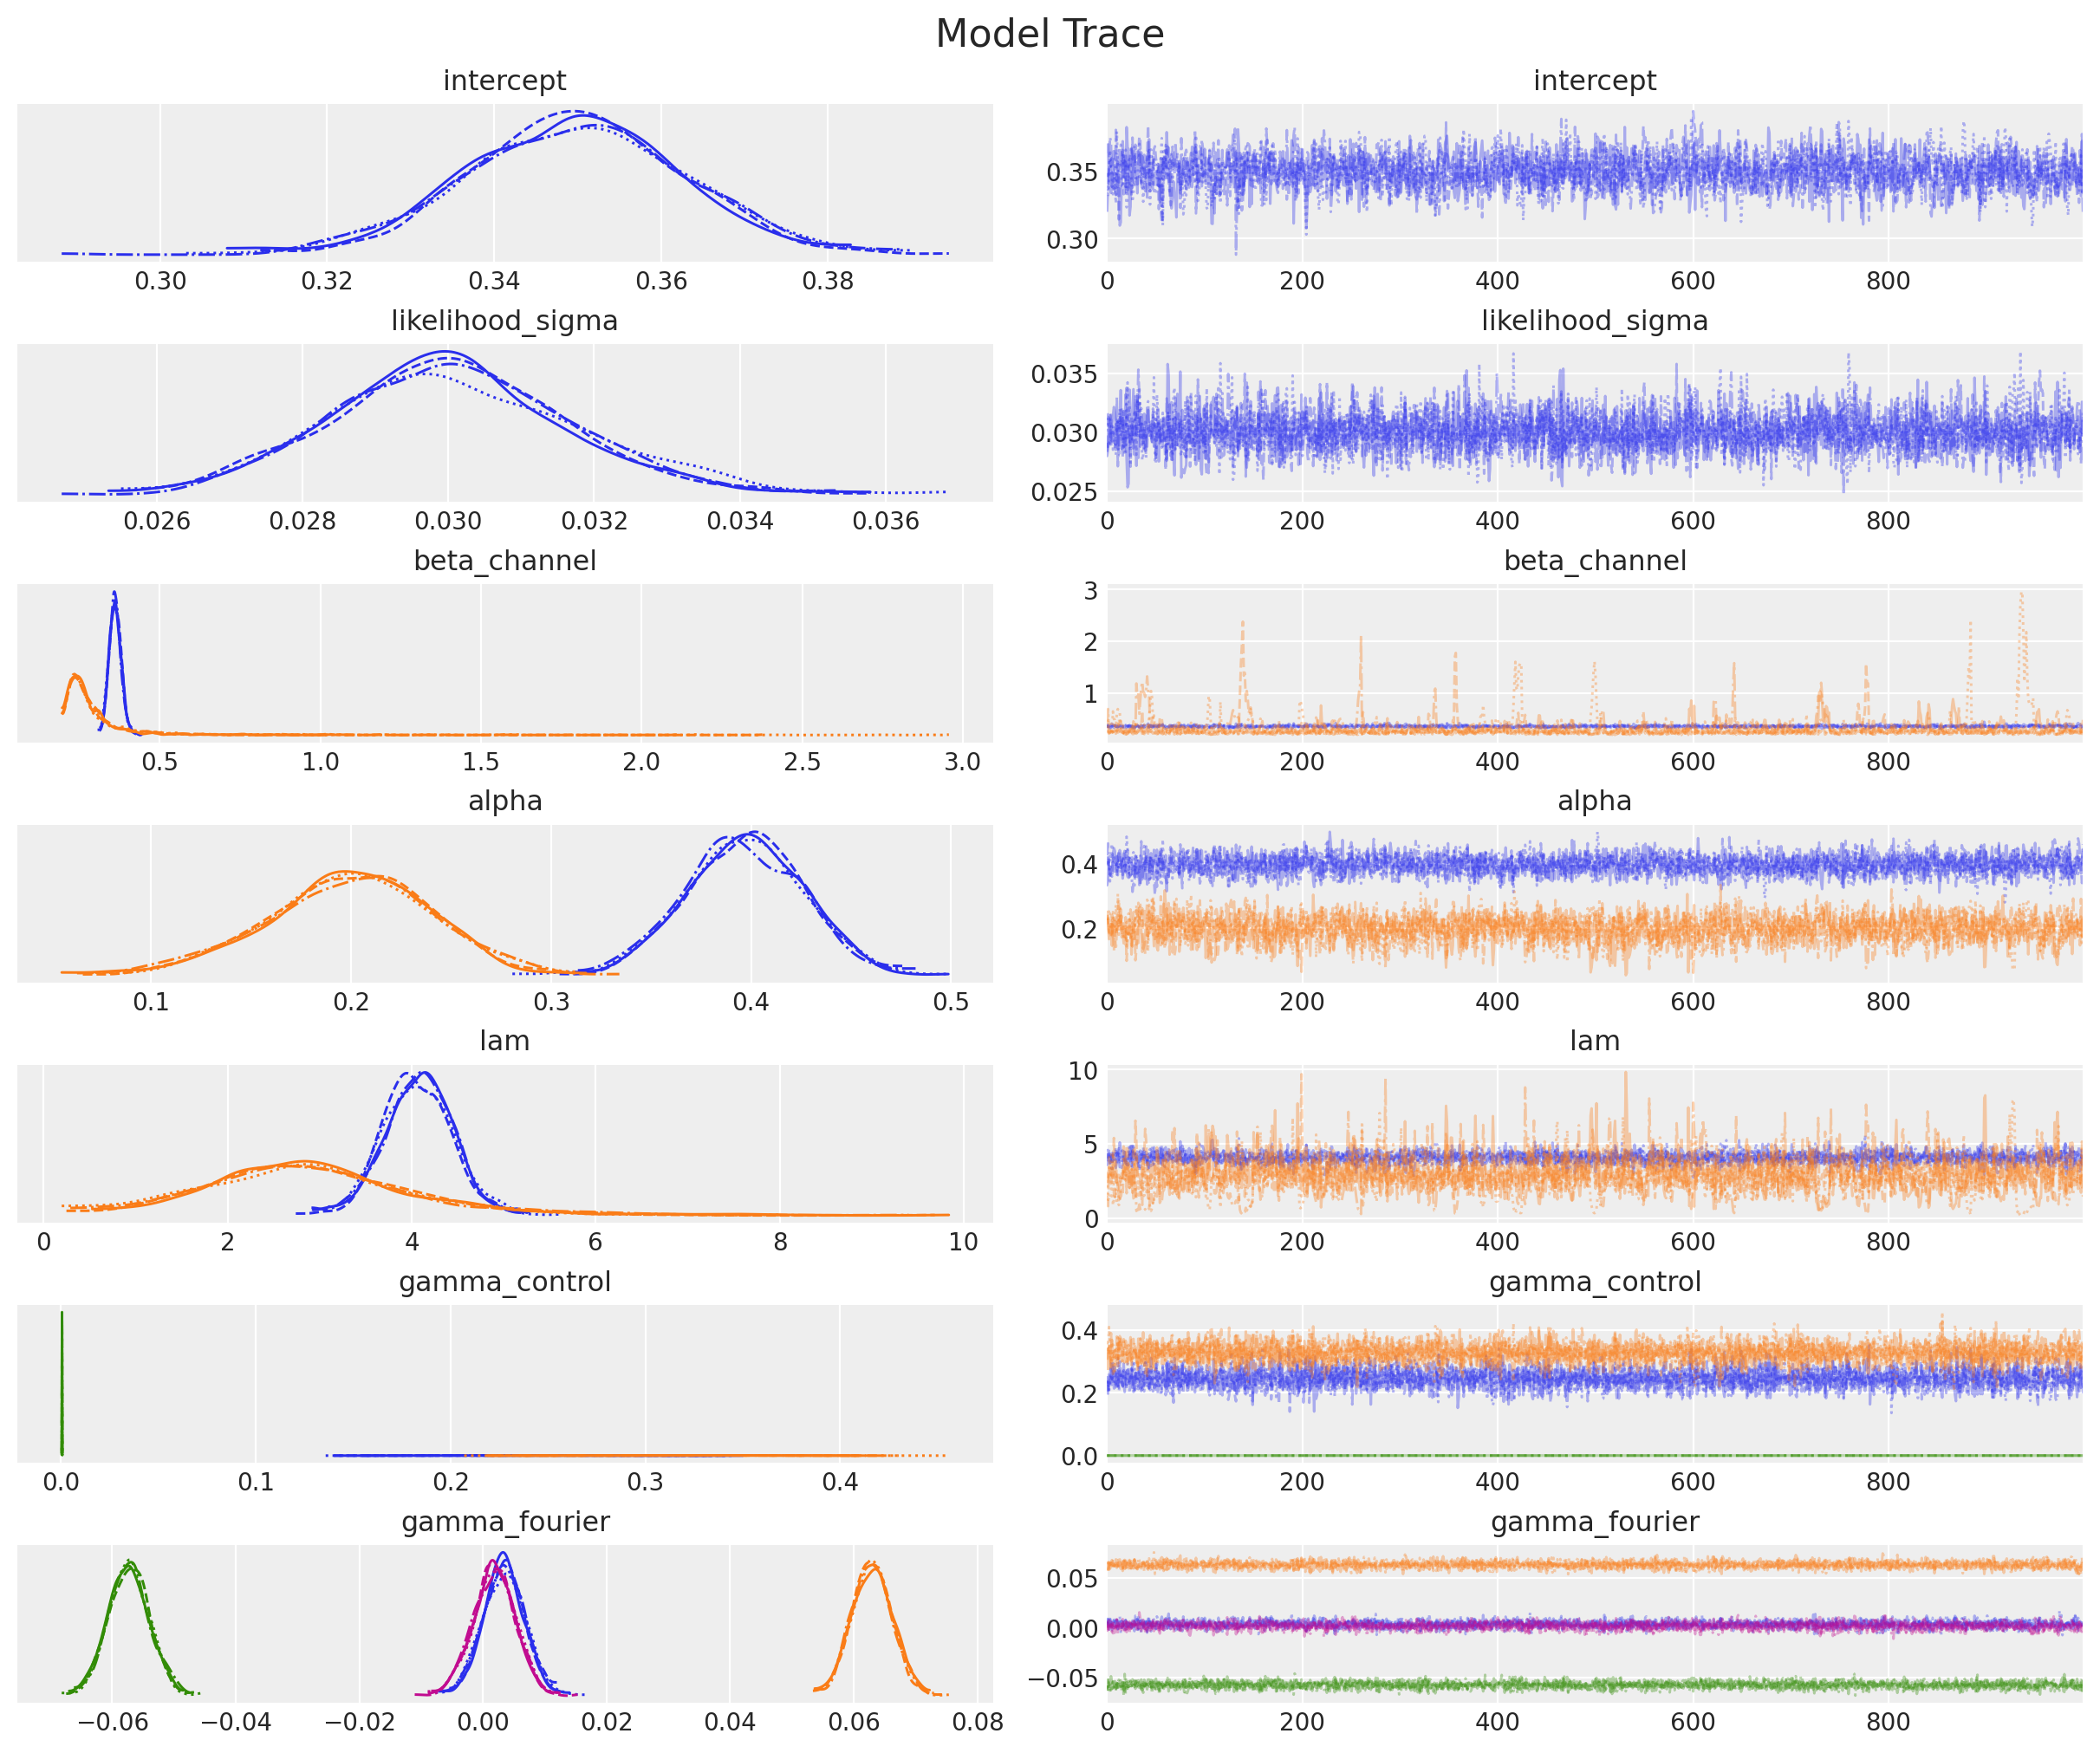

In [26]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [27]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


<xarray.Dataset>
Dimensions:  (date: 179, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 3.704 4.281 4.215 ... 4.797 4.936 4.559
Attributes:
    created_at:                 2024-02-14T11:56:35.895440
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

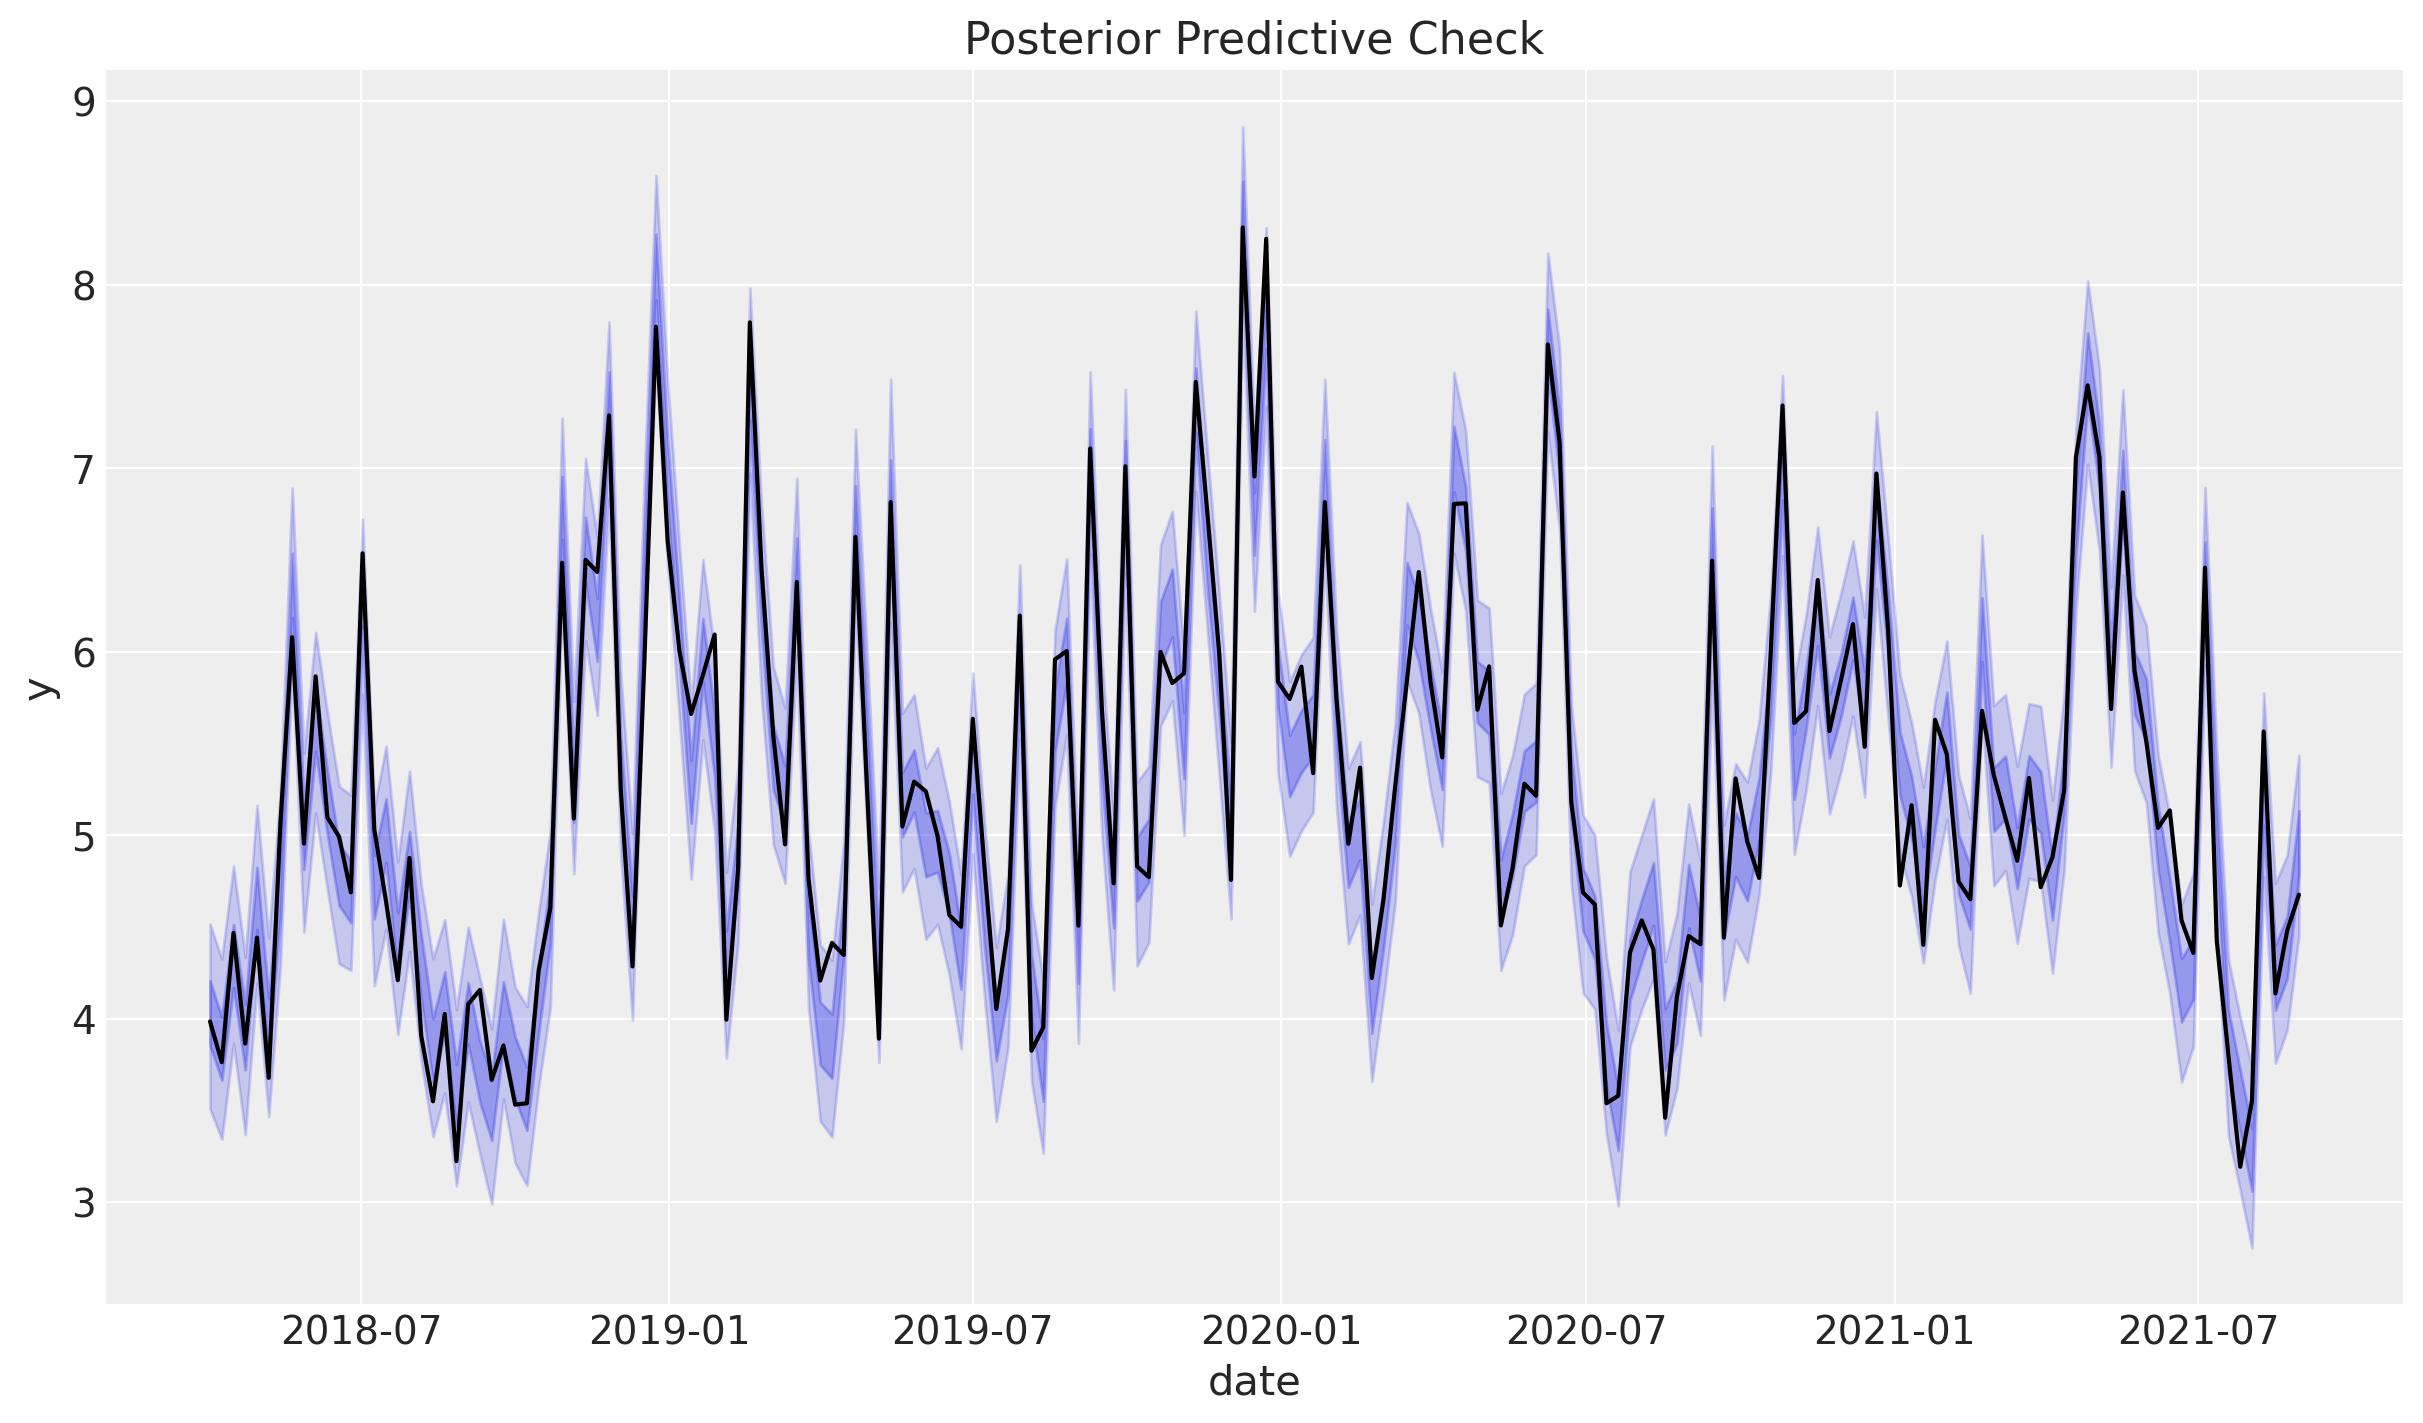

In [28]:
mmm.plot_posterior_predictive(original_scale=True);

- The black line is the real sale, and the purple one is the predictive result.

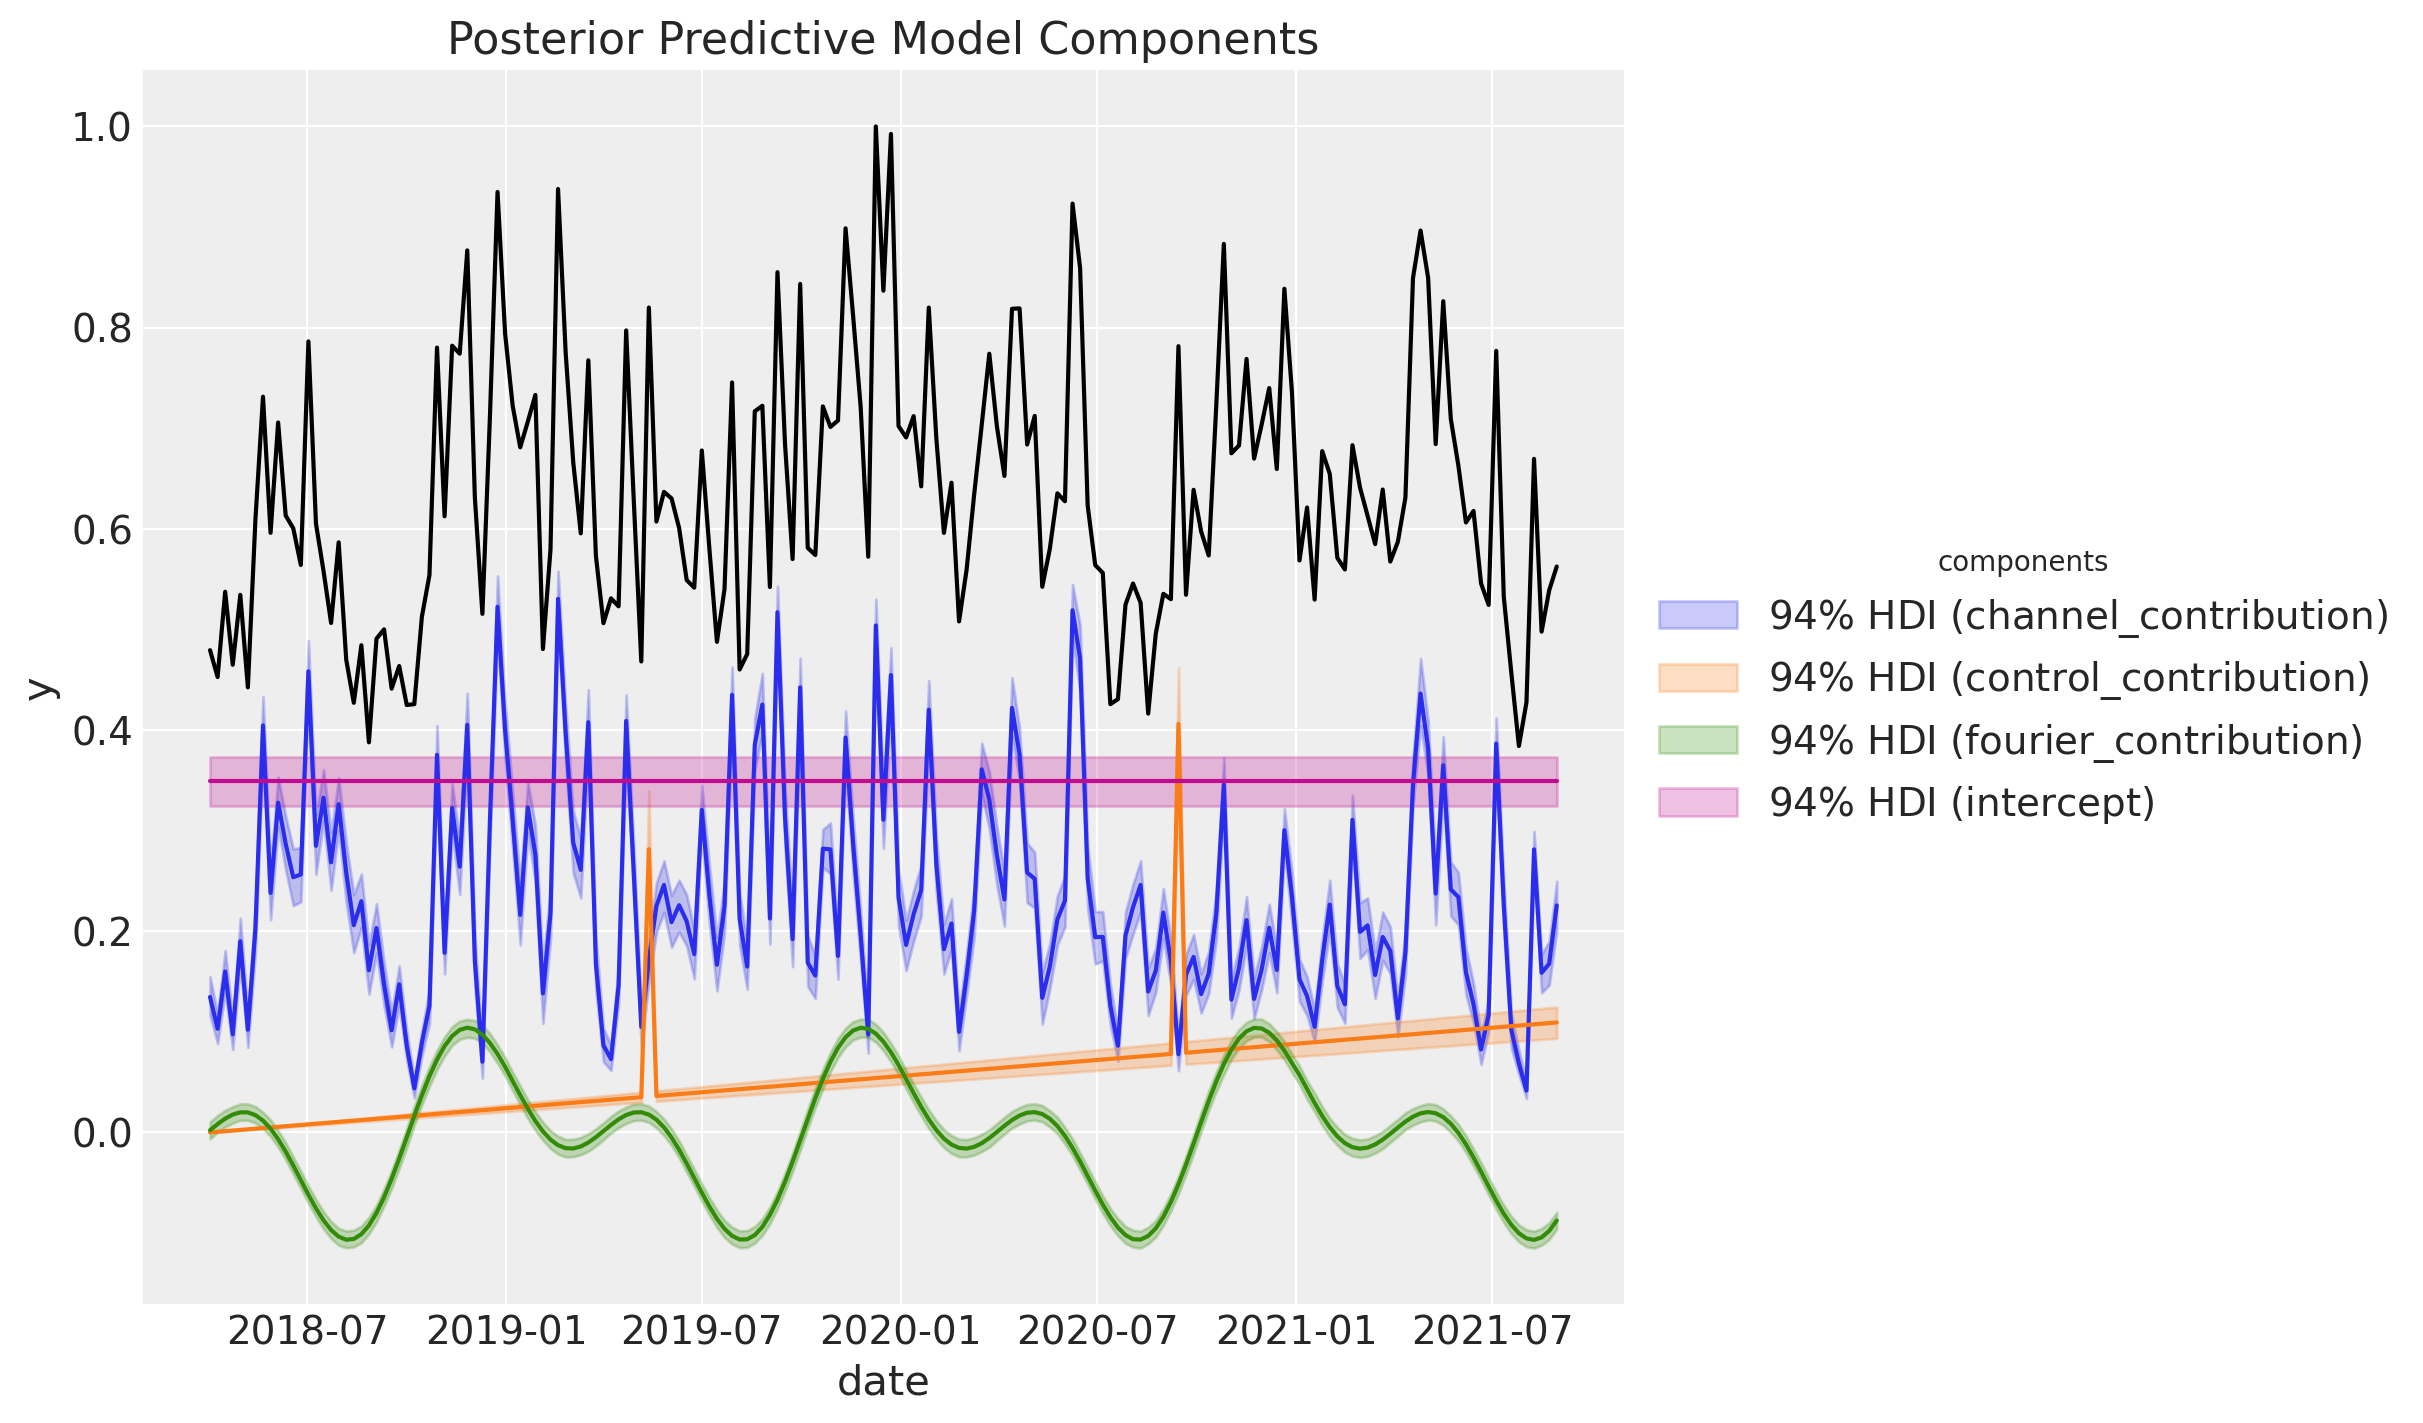

In [29]:
mmm.plot_components_contributions();

- This shows how each channel and non-media factor contribute to the sales.
- The blue line represents channels; the orange line represents non-media factors such as price, promotion etc; the green line represents the seasonality.

In [30]:
mmm.get_target_transformer()

Pipeline(steps=[('scaler', MaxAbsScaler())])

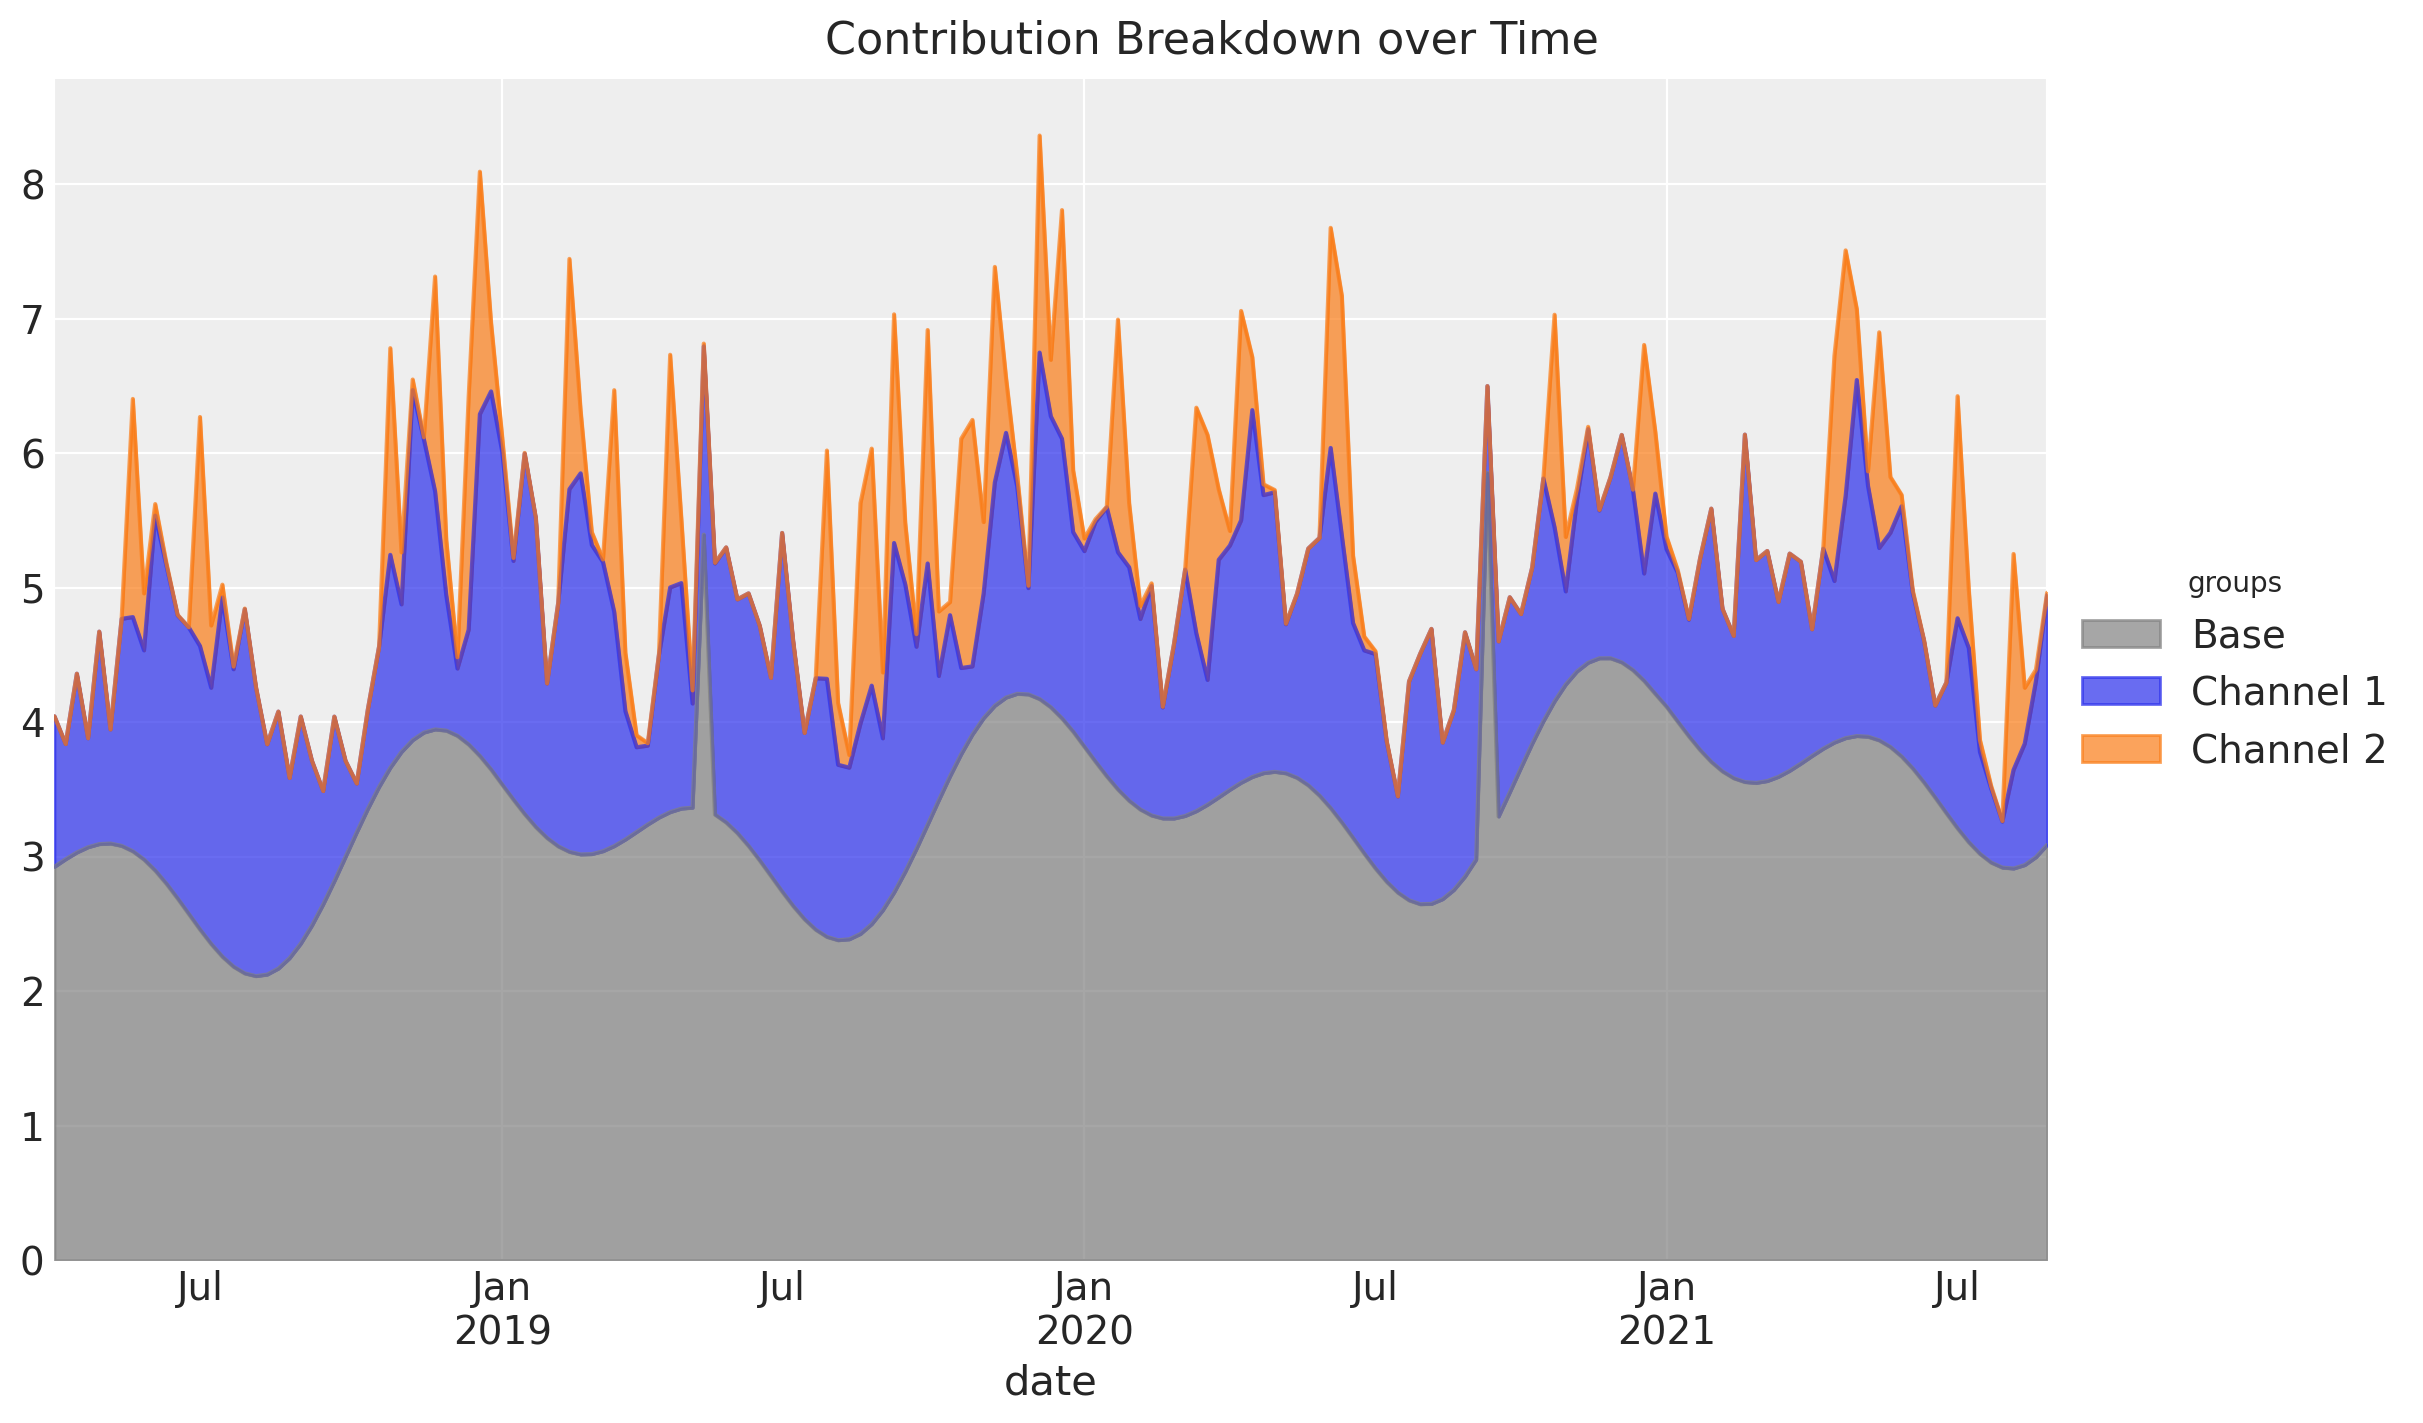

In [31]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "sin_order_2",
        "cos_order_1",
        "cos_order_2",
    ],
    "Channel 1": ["x1"],
    "Channel 2": ["x2"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "Channel 1": "C0",
            "Channel 2": "C1",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

 - We can tell that channel 1 works better in terms of generating sales.

In [32]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

x1   x2  event_1  event_2         t  sin_order_1  \
date                                                                 
2018-04-02  1.118788  0.0      0.0      0.0  0.000000     0.028033   
2018-04-09  0.856492  0.0      0.0      0.0  0.005103     0.027790   
2018-04-16  1.329314  0.0      0.0      0.0  0.010206     0.027144   
2018-04-23  0.810445  0.0      0.0      0.0  0.015309     0.026106   
2018-04-30  1.579552  0.0      0.0      0.0  0.020411     0.024690   

            cos_order_1  sin_order_2  cos_order_2  intercept  
date                                                          
2018-04-02    -0.006187     0.011267    -0.015132   2.906463  
2018-04-09    -0.068980     0.124531    -0.014610   2.906463  
2018-04-16    -0.130774     0.230607    -0.013245   2.906463  
2018-04-23    -0.190674     0.323372    -0.011115   2.906463  
2018-04-30    -0.247812     0.397471    -0.008343   2.906463

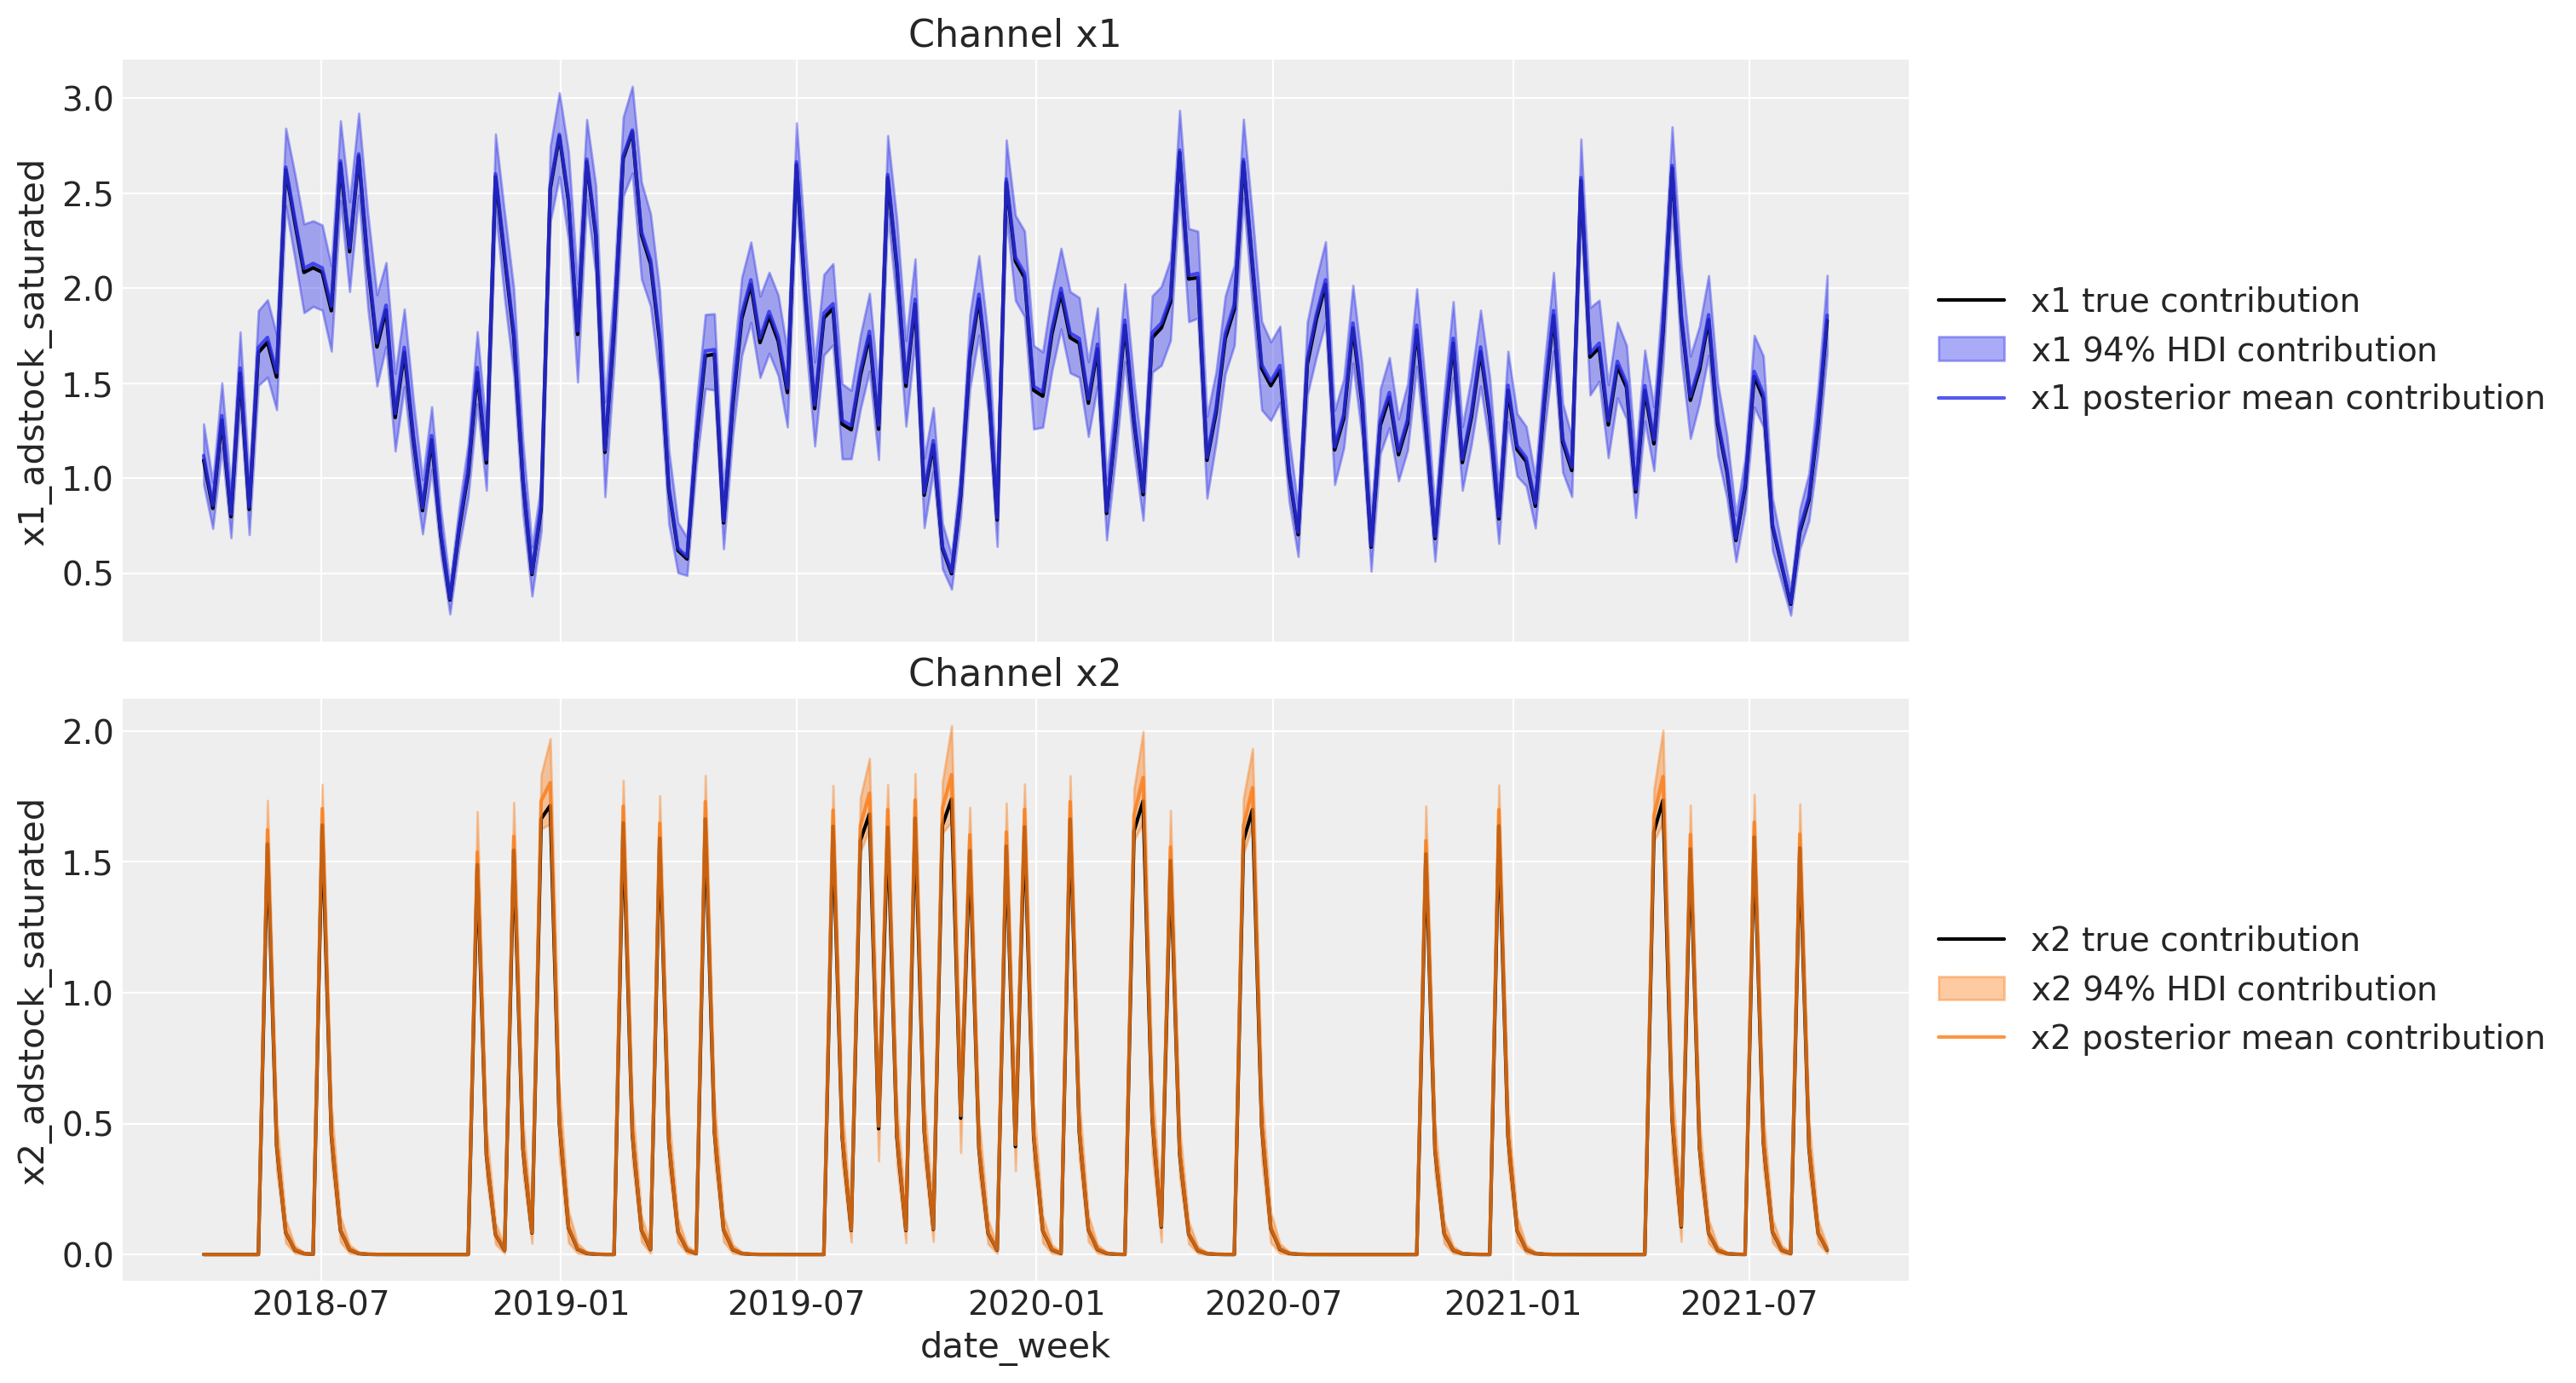

In [39]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=df["date_week"],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color="black",
        label=f"{x} true contribution",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=df["date_week"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=f"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=df["date_week"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        alpha=0.8,
        ax=ax[i],
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

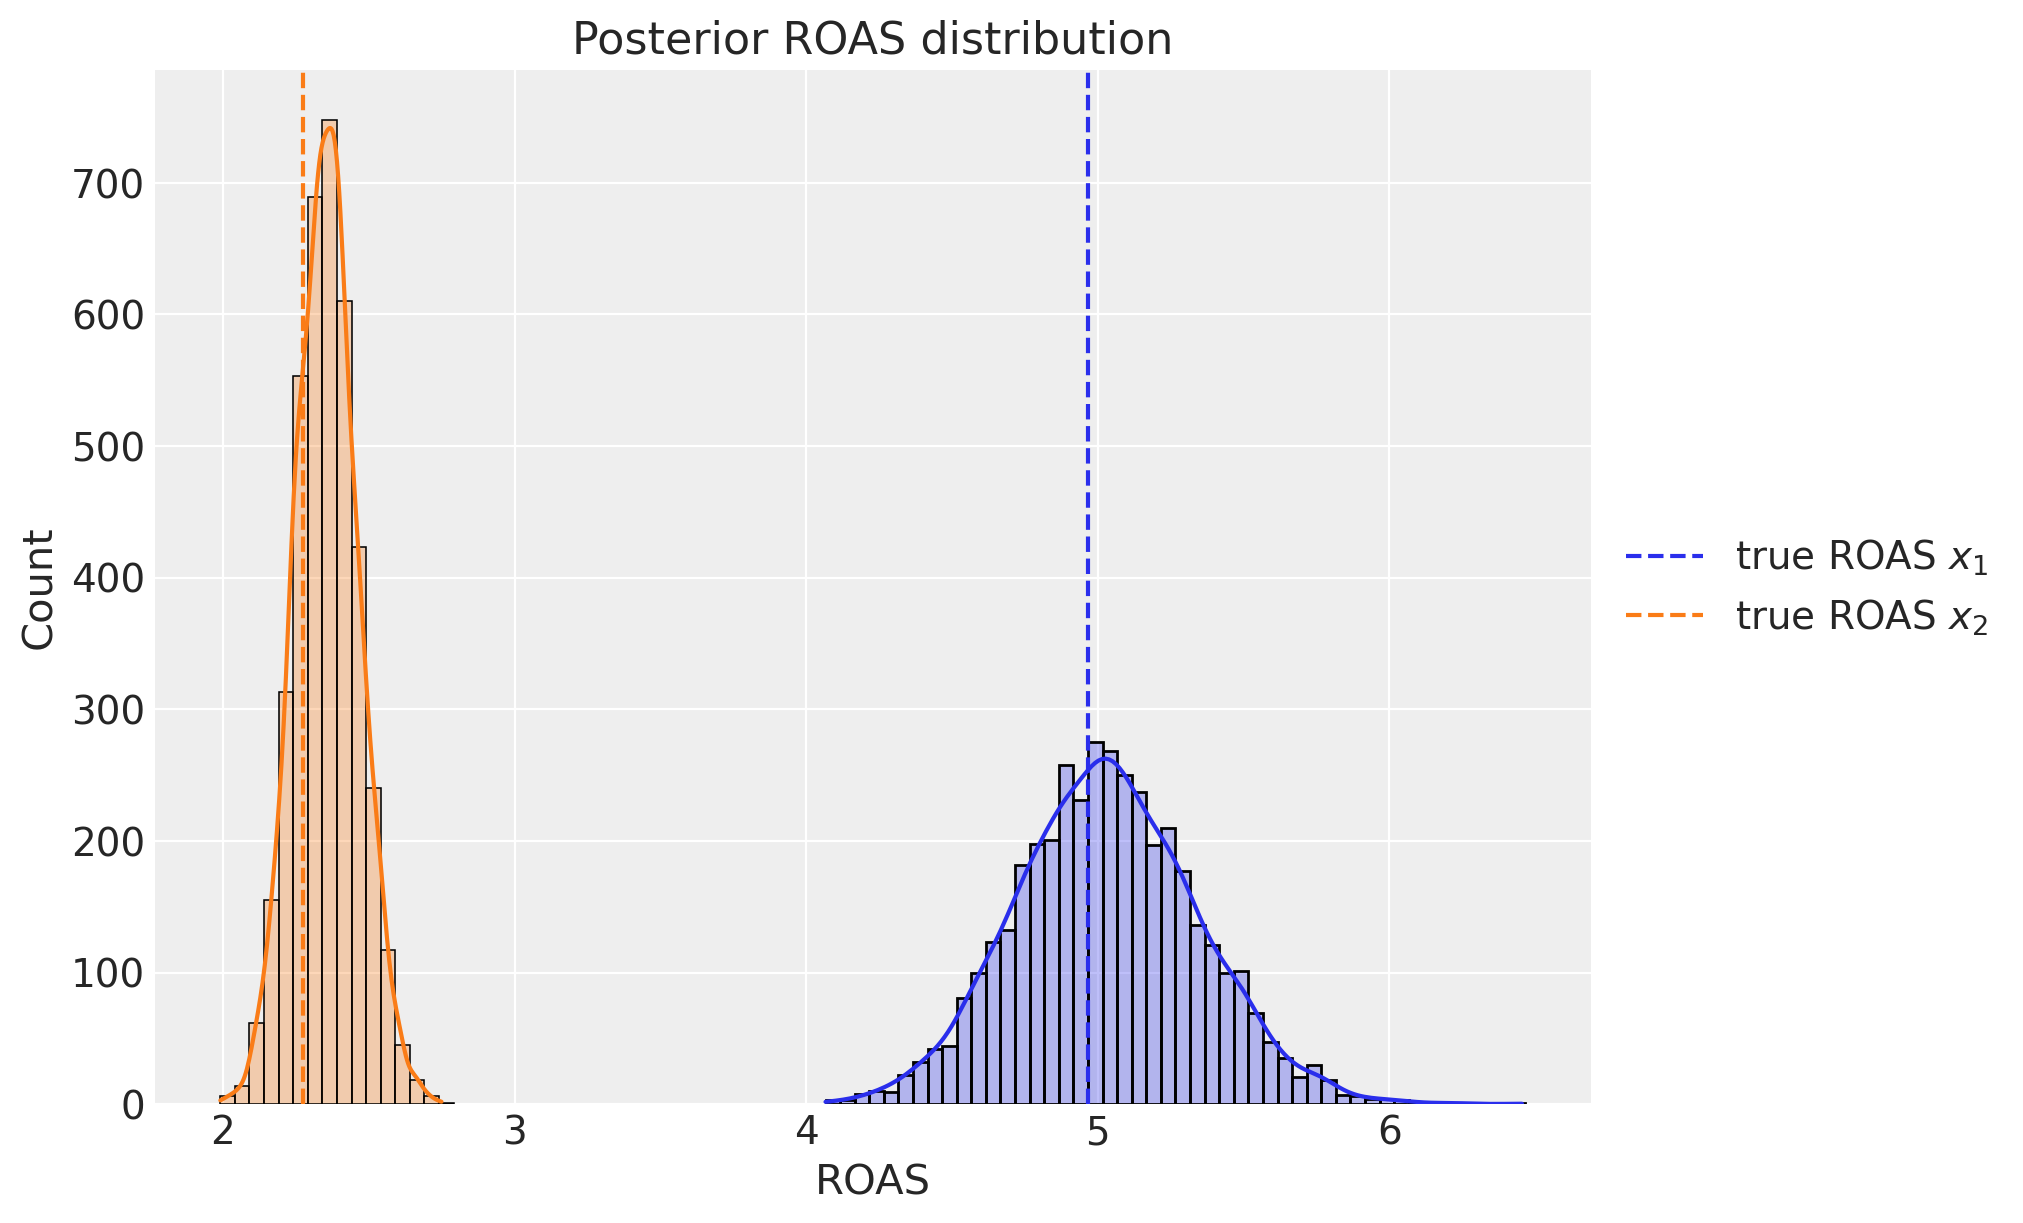

In [40]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

- It does show channel 1 has a better ROAS.